## Educational analytic case with McDonalds and Starbucks menu: what would be better as meals for teens?

[Case description] Restrictions from the task description [Restrictions, document-1 = link, document-2 = link]

DONE:
- values from norms (document-1) extracted manually --> txt --> dict. We find only 6 values: Energy(kcal), Fat(g), Carbohydrates(g), Fiber(g), Protein(g), Sodium (g), wich exist in all three datasets (document-1, McD and SB menus)
- values from McD and SB .csv menus --> Excel --> (processing: combine, add features in cols, enrichment)
- features added: (1) 'McD=0_SB=1': restraunt coding, (2) 'Category': food/drink, (3) 'Kind': bakery/breakfast/hot drink etc.
- dataset enriched manually: about 60 items in 'Snacks & sweets' category were added for SB menu. Thus we have more balanced dataaset (McD/SB share).
- discard from zeroes: dividing all mass values by 1000 (mg --> g)
- several bug fixes in values
- deleted items with all zeroes
- calculate weighted norms - according the rule requirement from official document-2
- deleting dishes with > 60% (breakfast + dinner) of day norm caloric or nutrition values (for instance, 1880 kcal (40 pieces of chicken McNuggets)

PLAN:
- include potential allergics - new feature?
- add the data on serving sizes
- search for nutrition indices or calculate integrated nutrition index (may be Carb:Fat:Prot matching those in norms?) and visualize it
- develop the decision making algorithm for combining potential breakfast and dinner sets 
- test the algorithm, corrections
- extract the results, preference for hot dishes and moderate-sugared drinks

In [413]:
# required imports
import pandas as pd
import numpy as np
from itertools import product, combinations
from matplotlib import pyplot as plt
%matplotlib inline

### Official norms

In [414]:
# Dict with actual norms (from official document-1)
norms = {}

f = open ('actual_norms.txt')

for line in f:
    line = line.strip().split(',')
    norms[line[0]] = line[1]
    
del norms['Item']
norms

{'Energy(kcal)': '2900',
 'Fat(g)': '97',
 'Carbohydrates(g)': '421',
 'Fiber(g)': '20',
 'Protein(g)': '87',
 'Sodium(g)': '1.3'}

In [415]:
# (From official document-2): 
# -breakfast + dinner = 20-25% + 30-35% daily energy value respectively --> 
# 25% and 35% (max due to sports competitions)
# -breakfast + dinner = 55-60% total daily nutrients value --> 
# 25% and 35% (max due to sports competitions)
# (only breakfast and dinner mentioned in the task)

# calculating weighted norms:

breakfast_norm, dinner_norm = {},{}

for key, value in norms.items():
    breakfast_norm[key] = float(value)*0.25
    dinner_norm[key] = float(value)*0.35
    
# sum_norm dict for data filtering (del items which contain greater values). Via dict generator:   
sum_norm = {key:float(value)*0.6 for key, value in norms.items()}
    
print (breakfast_norm)
print (dinner_norm)
print (sum_norm)

{'Energy(kcal)': 725.0, 'Fat(g)': 24.25, 'Carbohydrates(g)': 105.25, 'Fiber(g)': 5.0, 'Protein(g)': 21.75, 'Sodium(g)': 0.325}
{'Energy(kcal)': 1014.9999999999999, 'Fat(g)': 33.949999999999996, 'Carbohydrates(g)': 147.35, 'Fiber(g)': 7.0, 'Protein(g)': 30.45, 'Sodium(g)': 0.45499999999999996}
{'Energy(kcal)': 1740.0, 'Fat(g)': 58.199999999999996, 'Carbohydrates(g)': 252.6, 'Fiber(g)': 12.0, 'Protein(g)': 52.199999999999996, 'Sodium(g)': 0.78}


### McD & SB menus

In [416]:
# Starbucks (SB) and McDonalds (McD) combined menu in single df: 
menu_df = pd.read_csv ('combined_menu_300919.csv', sep=';', encoding = 'koi8-r')
menu_df.head()

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
0,1,food,Bakery,Chonga Bagel,300,5.0,50,3.0,12,0.53
1,1,food,Bakery,8-Grain Roll,380,6.0,70,7.0,10,0.43
2,1,food,Bakery,Almond Croissant,410,22.0,45,3.0,10,0.39
3,1,food,Bakery,Banana Nut Bread,420,22.0,52,2.0,6,0.32
4,1,food,Bakery,Birthday Cake Pop,170,9.0,23,0.0,1,0.11


In [417]:
# checking data gaps - it's OK
menu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
McD=0_SB=1          500 non-null int64
Category            500 non-null object
Kind                500 non-null object
Item                500 non-null object
Energy(kcal)        500 non-null int64
Fat(g)              500 non-null float64
Carbohydrates(g)    500 non-null int64
Fiber(g)            500 non-null float64
Protein(g)          500 non-null int64
Sodium(g)           500 non-null float64
dtypes: float64(3), int64(4), object(3)
memory usage: 39.1+ KB


### Clean the data

In [418]:
# any all-zero items to delete?
del_list = []
def find_zeroes (row):
    '''the function recieve row of a df and process it: if all quantitative fields 
    are zeroes in the row, the row included in list for deleting'''
    if row[4:].sum() == 0:
#         print (row)
        del_list.append (row[3])
        
menu_df.apply (find_zeroes, axis = 1)
menu_df = menu_df.loc[~menu_df['Item'].isin(del_list)]
len (menu_df) # 7 values deleted

493

In [419]:
# filtering: del items which contain values greater than weighted norm in sum_norm dict:

menu_df[menu_df['Energy(kcal)']>=sum_norm['Energy(kcal)']]
# only 1 item exceeds sum_norms (1740 kcal)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
322,0,food,Sandwiches/Burgers,Chicken McNuggets (40 piece),1880,118.0,118,6.0,87,3.6


In [420]:
menu_df[menu_df['Fat(g)']>=sum_norm['Fat(g)']]
# 3 items exceed sum_norms (58.2 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
272,0,food,Hot Breakfast,Big Breakfast with Hotcakes (Large Biscuit),1150,60.0,116,7.0,36,2.26
321,0,food,Sandwiches/Burgers,Chicken McNuggets (20 piece),940,59.0,59,3.0,44,1.80
322,0,food,Sandwiches/Burgers,Chicken McNuggets (40 piece),1880,118.0,118,6.0,87,3.60


In [421]:
menu_df[menu_df['Carbohydrates(g)']>=sum_norm['Carbohydrates(g)']]
# no items exceed sum_norms

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)


In [422]:
menu_df[menu_df['Fiber(g)']>=sum_norm['Fiber(g)']]
# 2 items exceed sum_norms (12.0 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
56,1,food,Protein Boxes & Bowls,Lentils & Vegetable Protein Bowl with Brown Rice,650,29.0,80,21.0,23,0.67
114,1,food,Fruit & Nuts,Bare Fruit Medley,130,0.0,31,24.0,1,0.00


In [423]:
menu_df[menu_df['Protein(g)']>=sum_norm['Protein(g)']]
# only 1 item exceeds sum_norms (52.2 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
322,0,food,Sandwiches/Burgers,Chicken McNuggets (40 piece),1880,118.0,118,6.0,87,3.6


In [424]:
menu_df[menu_df['Sodium(g)']>=sum_norm['Sodium(g)']]
# Wow! 104 items exceed sum_norms (0.78 g)

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
36,1,food,Cold Sandwiches,Chicken & Fig Spread,460,13.0,61,5.0,24,0.94
37,1,food,Cold Sandwiches,Chipotle Chicken Wrap,470,19.0,55,4.0,22,1.05
38,1,food,Protein Boxes & Bowls,Farmers' Market Protein Box,470,29.0,29,4.0,21,0.88
40,1,food,Warm Sandwiches,Grilled Chicken & Cauliflower Tabbouleh,390,27.0,15,4.0,21,1.14
41,1,food,Warm Sandwiches,Honey BBQ Sriracha Chicken Sandwich,360,7.0,52,3.0,22,1.09
43,1,food,Cold Sandwiches,Roasted Turkey & Dill Havarti Sandwich,600,32.0,47,6.0,32,0.86
44,1,food,Warm Sandwiches,Seasoned Turkey & Green Pepper Pico,390,18.0,30,5.0,28,0.90
45,1,food,Warm Sandwiches,Smoked Mozzarella & Roasted Pepper Sandwich,500,28.0,46,4.0,18,1.19
46,1,food,Warm Sandwiches,Smoked Pork Cubano,450,25.0,66,5.0,21,1.20
48,1,food,Warm Sandwiches,Turkey Pastrami Reuben,500,21.0,50,4.0,26,1.13


In [425]:
# Well, lets assume that salt needs increases due to sports: 1.0 g sodium threshold:
menu_df[menu_df['Sodium(g)']>=1]
# Nevertheless 73 items exceed 1.0 g

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g)
37,1,food,Cold Sandwiches,Chipotle Chicken Wrap,470,19.0,55,4.0,22,1.05
40,1,food,Warm Sandwiches,Grilled Chicken & Cauliflower Tabbouleh,390,27.0,15,4.0,21,1.14
41,1,food,Warm Sandwiches,Honey BBQ Sriracha Chicken Sandwich,360,7.0,52,3.0,22,1.09
45,1,food,Warm Sandwiches,Smoked Mozzarella & Roasted Pepper Sandwich,500,28.0,46,4.0,18,1.19
46,1,food,Warm Sandwiches,Smoked Pork Cubano,450,25.0,66,5.0,21,1.20
48,1,food,Warm Sandwiches,Turkey Pastrami Reuben,500,21.0,50,4.0,26,1.13
51,1,food,Protein Boxes & Bowls,Chicken & Quinoa Protein Bowl with Black Beans...,420,17.0,42,9.0,27,1.03
52,1,food,Protein Boxes & Bowls,Chicken BLT Protein Box,580,23.0,58,7.0,35,1.66
53,1,food,Protein Boxes & Bowls,Chicken Wrap Protein Box,460,22.0,45,4.0,20,1.00
58,1,food,Protein Boxes & Bowls,Smoked Turkey Protein Box,360,12.0,42,5.0,24,1.62


In [426]:
# Let's drop out all items that exceeds the criteria:
menu_df = menu_df[menu_df['Energy(kcal)'] < sum_norm['Energy(kcal)']]
menu_df = menu_df[menu_df['Fat(g)'] < sum_norm['Fat(g)']]
menu_df = menu_df[menu_df['Fiber(g)'] < sum_norm['Fiber(g)']]
menu_df = menu_df[menu_df['Protein(g)'] < sum_norm['Protein(g)']]
menu_df = menu_df[menu_df['Sodium(g)'] < 1.0]

len (menu_df)

418

In [427]:
# We increased the sodium sum norm 0.78 --> 1.0, i.e. +0.22. 
# Let's assume that in turns it increases breakfast and dinner 
# sodium norms equally: by 0.11 g. Norm dicts update:
breakfast_norm['Sodium(g)'] += 0.11
dinner_norm['Sodium(g)'] += 0.11
sum_norm['Sodium(g)'] += 0.22
print (breakfast_norm)
print (dinner_norm)
print (sum_norm)

{'Energy(kcal)': 725.0, 'Fat(g)': 24.25, 'Carbohydrates(g)': 105.25, 'Fiber(g)': 5.0, 'Protein(g)': 21.75, 'Sodium(g)': 0.435}
{'Energy(kcal)': 1014.9999999999999, 'Fat(g)': 33.949999999999996, 'Carbohydrates(g)': 147.35, 'Fiber(g)': 7.0, 'Protein(g)': 30.45, 'Sodium(g)': 0.565}
{'Energy(kcal)': 1740.0, 'Fat(g)': 58.199999999999996, 'Carbohydrates(g)': 252.6, 'Fiber(g)': 12.0, 'Protein(g)': 52.199999999999996, 'Sodium(g)': 1.0}


### Visualizations

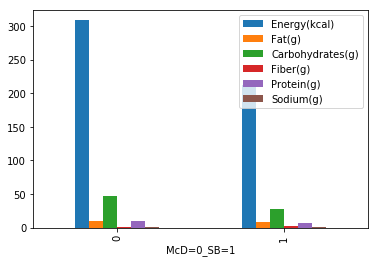

In [428]:
# all means for McD and SB menu
means = menu_df.groupby ('McD=0_SB=1').mean()
means.plot(kind = 'bar')

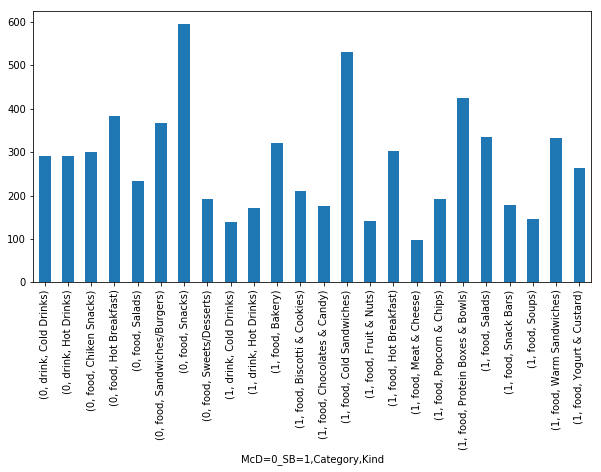

In [429]:
# All mean caloric values:
means_all = menu_df.groupby (['McD=0_SB=1', 'Category', 'Kind']).mean()
means_all['Energy(kcal)'].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 0.5, figsize = (10,5))

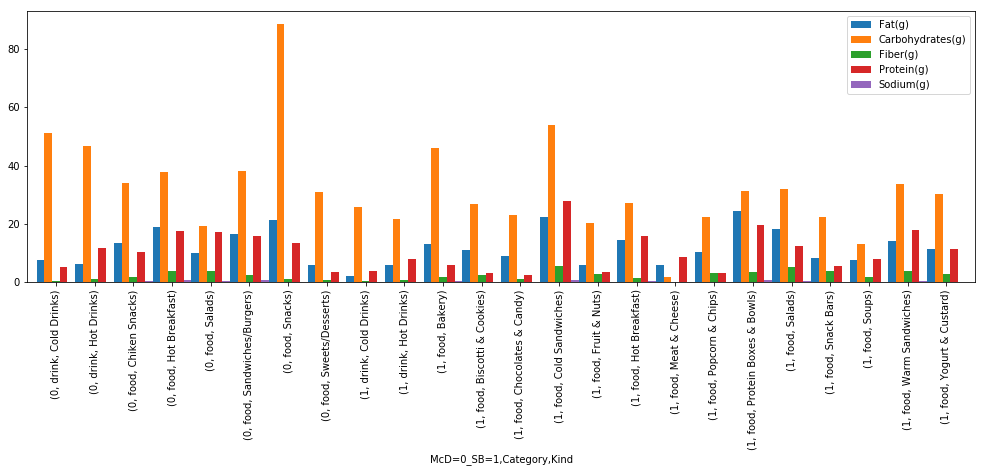

In [430]:
# All mean nutrition values:
means_all[['Fat(g)', 
          'Carbohydrates(g)', 
          'Fiber(g)', 
          'Protein(g)', 
          'Sodium(g)']].plot(kind = 'bar', subplots = False, sharex=True, sharey=False, width = 1, figsize = (17,5))

### Idea for core algorithm for menu making 
0. Manually splitting the data to two near equal subsets for breakfast and for dinner <b>[PASSED]</b>
1. Normalize values of all items in breakfast subset by dividing them on breakfast_norm values dict, and in dinner subset by dividing them on dinner_norm values dict. If (0) = [PASSED], make two copies of the whole dataset: normalized for breakfast and  normalized for dinner. <b>[DONE]</b>
2. Develop the format of breakfast / dinner (for instance, [1-st food item, 2-nd food item, 3-rd drink item]) <b>[DONE]</b>
3. Build a meal-maker function (dataset, format) which returns a result_dataset of random combitations of items from dataset categories specified in format template <b>[DONE]</b>
4. Build an quality assement function, which recieves result_dataset and evaluate caloric and nutrition: 6 total values derived from all items in certain breakfast / dinner combitation and returns 'B-index' (Balance index): how that combination fits the norms. If 'B-index' close to 0 (StDev of six values that normalized as share of 1, noted above in p.1) the meal combination well fitted <b>[DONE]</b>
5. Evaluation of SB VS McD menus by this algorithm and draw the conclusions

In [431]:
# normalizing whole dataset for breakfast --> new features:
for item in menu_df[['Energy(kcal)','Fat(g)', 'Carbohydrates(g)','Fiber(g)', 'Protein(g)', 'Sodium(g)']]:
    for key in breakfast_norm:
        if key == item:
            menu_df['b_'+item] = menu_df[item] / float (breakfast_norm[key])

# and for dinner:
for item in menu_df[['Energy(kcal)','Fat(g)', 'Carbohydrates(g)','Fiber(g)', 'Protein(g)', 'Sodium(g)']]:
    for key in dinner_norm:
        if key == item:
            menu_df['d_'+item] = menu_df[item] / float (dinner_norm[key])

menu_df
# menu_df.to_csv('menu_normalized.csv')

,McD=0_SB=1,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g),...,b_Carbohydrates(g),b_Fiber(g),b_Protein(g),b_Sodium(g),d_Energy(kcal),d_Fat(g),d_Carbohydrates(g),d_Fiber(g),d_Protein(g),d_Sodium(g)
0,1,food,Bakery,Chonga Bagel,300,5.0,50,3.0,12,0.530,...,0.475059,0.6,0.551724,1.218391,0.295567,0.147275,0.339328,0.428571,0.394089,0.938053
1,1,food,Bakery,8-Grain Roll,380,6.0,70,7.0,10,0.430,...,0.665083,1.4,0.459770,0.988506,0.374384,0.176730,0.475059,1.000000,0.328407,0.761062
2,1,food,Bakery,Almond Croissant,410,22.0,45,3.0,10,0.390,...,0.427553,0.6,0.459770,0.896552,0.403941,0.648012,0.305395,0.428571,0.328407,0.690265
3,1,food,Bakery,Banana Nut Bread,420,22.0,52,2.0,6,0.320,...,0.494062,0.4,0.275862,0.735632,0.413793,0.648012,0.352901,0.285714,0.197044,0.566372
4,1,food,Bakery,Birthday Cake Pop,170,9.0,23,0.0,1,0.110,...,0.218527,0.0,0.045977,0.252874,0.167488,0.265096,0.156091,0.000000,0.032841,0.194690
5,1,food,Bakery,Blueberry Muffin,360,15.0,52,1.0,5,0.270,...,0.494062,0.2,0.229885,0.620690,0.354680,0.441826,0.352901,0.142857,0.164204,0.477876
6,1,food,Bakery,Blueberry Oat Cake,390,12.0,71,7.0,7,0.430,...,0.674584,1.4,0.321839,0.988506,0.384236,0.353461,0.481846,1.000000,0.229885,0.761062
7,1,food,Bakery,Blueberry Scone,420,17.0,61,2.0,5,0.350,...,0.579572,0.4,0.229885,0.804598,0.413793,0.500736,0.413980,0.285714,0.164204,0.619469
8,1,food,Bakery,Butter Croissant,240,12.0,28,1.0,5,0.320,...,0.266033,0.2,0.229885,0.735632,0.236453,0.353461,0.190024,0.142857,0.164204,0.566372
9,1,food,Bakery,Cheese Danish,320,16.0,36,1.0,8,0.400,...,0.342043,0.2,0.367816,0.919540,0.315271,0.471281,0.244316,0.142857,0.262726,0.707965


In [432]:
# how many items of McD / SB remains:
menu_df.groupby(by=['McD=0_SB=1']).count()

,Category,Kind,Item,Energy(kcal),Fat(g),Carbohydrates(g),Fiber(g),Protein(g),Sodium(g),b_Energy(kcal),...,b_Carbohydrates(g),b_Fiber(g),b_Protein(g),b_Sodium(g),d_Energy(kcal),d_Fat(g),d_Carbohydrates(g),d_Fiber(g),d_Protein(g),d_Sodium(g)
McD=0_SB=1,,,,,,,,,,,,,,,,,,,,,
0,201,201,201,201,201,201,201,201,201,201,...,201,201,201,201,201,201,201,201,201,201
1,217,217,217,217,217,217,217,217,217,217,...,217,217,217,217,217,217,217,217,217,217


In [433]:
# splitting data to two subsets, reindexing:
SB_menu = menu_df.iloc[0:217]
SB_menu.drop(['McD=0_SB=1', 'Energy(kcal)', 'Fat(g)', 'Carbohydrates(g)', 'Fiber(g)', 'Protein(g)', 'Sodium(g)'], axis=1, inplace=True)
SB_menu.reset_index(drop=True, inplace=True)
McD_menu = menu_df.iloc[217:]
McD_menu.drop(['McD=0_SB=1', 'Energy(kcal)', 'Fat(g)', 'Carbohydrates(g)', 'Fiber(g)', 'Protein(g)', 'Sodium(g)'], axis=1, inplace=True)
McD_menu.reset_index(drop=True, inplace=True)

C:\Users\u1\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [434]:
McD_menu['Kind'].unique()

array(['Hot Breakfast', 'Sandwiches/Burgers', 'Salads', 'Chiken Snacks',
       'Sweets/Desserts', 'Snacks', 'Cold Drinks', 'Hot Drinks'],
      dtype=object)

In [435]:
SB_menu['Kind'].unique()

array(['Bakery', 'Salads', 'Cold Sandwiches', 'Protein Boxes & Bowls',
       'Warm Sandwiches', 'Yogurt & Custard', 'Soups', 'Hot Breakfast',
       'Biscotti & Cookies', 'Chocolates & Candy', 'Fruit & Nuts',
       'Popcorn & Chips', 'Meat & Cheese', 'Snack Bars', 'Cold Drinks',
       'Hot Drinks'], dtype=object)

In [436]:
# Let's design the breakfast / dinner formats ('kinds') from above catrgories.

k1, k2, k3 = [], [], []

def kind_lists (row, kinds=['Hot Breakfast', 'Fruit & Nuts', 'Hot Drinks']):
    
    '''making lists of all items that matches with respective kind in 'kinds' format
    3 kind-format --> 3 lists of items'''

    if kinds[0] in row[1]:
        k1.append (list ([row[2], row[3], row[4], row[5], row[6], row[7], row[8]])) # Well, not so
    if kinds[1] in row[1]:
        k2.append (list ([row[2], row[3], row[4], row[5], row[6], row[7], row[8]])) # elegant code...
    if kinds[2] in row[1]:
        k3.append (list ([row[2], row[3], row[4], row[5], row[6], row[7], row[8]])) # slices --> kernel dies
    
    return k1,k2,k3
    
SB_menu.apply (kind_lists, axis=1)

# make all non-repeated element-wise combinations of items (by default of 3 items = len (kinds))
arrays = [k1, k2, k3]
combinator = list(product(*arrays))
df_combi = pd.DataFrame (combinator)
df_combi.head()

,0,1,2
0,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Blonde Roast, 0.006896551724137931, 0.0, 0.0,..."
1,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Clover Brewed Coffee, 0.013793103448275862, 0..."
2,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Decaf Pike Place Roast, 0.006896551724137931,..."
3,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Featured Dark Roast, 0.006896551724137931, 0...."
4,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Pike Place Roast, 0.006896551724137931, 0.0, ..."


In [437]:
len (df_combi)

2340

In [438]:
# Let's evaluate all these combinations by their B-index. 
# (possibly it could be designed with more pythonic and elegant code =)

'''df-applied functions calculate weighted sums. Next is calculating of B-index 
    as sum of weighted (described above) values in row of elements representing 
    a cetrain breakfast variant.Returns same df featured by 6 weighted sums 
    and StDev of them (== B_index) column.
    
    So the lower B_index is - the more balanced items combination we found.
    If 'B-index' close to 0 (StDev of six values that normalized as share of 1, 
    noted above in p.1) the meal combination well fitted.'''

def e_sum (row):
    
    e_sum = row[0][1] + row[1][1] + row[2][1]
    return e_sum
    
def f_sum (row):   
    
    f_sum = row[0][2] + row[1][2] + row[2][2]
    return f_sum
    
def c_sum (row):       
    
    c_sum = row[0][3] + row[1][3] + row[2][3]
    return c_sum
    
def fi_sum (row):  
    fi_sum = row[0][4] + row[1][4] + row[2][4]
    return fi_sum
    
def p_sum (row): 
    
    p_sum = row[0][5] + row[1][5] + row[2][5]
    return p_sum
    
def s_sum (row):

    s_sum = row[0][6] + row[1][6] + row[2][6]
    return s_sum

In [439]:
# weighted sums for each estimated value for control:
df_combi['e_sum'] = df_combi.apply (e_sum, axis=1)
df_combi['f_sum'] = df_combi.apply (f_sum, axis=1)
df_combi['c_sum'] = df_combi.apply (c_sum, axis=1)
df_combi['fi_sum'] = df_combi.apply (fi_sum, axis=1)
df_combi['p_sum'] = df_combi.apply (p_sum, axis=1)
df_combi['s_sum'] = df_combi.apply (s_sum, axis=1)

# finally, B-index:
df_combi['B_index'] = df_combi.iloc[:,3:].std(axis=1)
df_combi.head ()

,0,1,2,e_sum,f_sum,c_sum,fi_sum,p_sum,s_sum,B_index
0,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Blonde Roast, 0.006896551724137931, 0.0, 0.0,...",0.668966,0.783505,0.56057,0.8,0.91954,1.816092,0.45345
1,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Clover Brewed Coffee, 0.013793103448275862, 0...",0.675862,0.783505,0.56057,0.8,0.91954,1.816092,0.45268
2,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Decaf Pike Place Roast, 0.006896551724137931,...",0.668966,0.783505,0.56057,0.8,0.91954,1.816092,0.45345
3,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Featured Dark Roast, 0.006896551724137931, 0....",0.668966,0.783505,0.56057,0.8,0.91954,1.816092,0.45345
4,"[Bacon Gouda & Egg Breakfast Sandwich, 0.51034...","[Banana, 0.15172413793103448, 0.0, 0.256532066...","[Pike Place Roast, 0.006896551724137931, 0.0, ...",0.668966,0.783505,0.56057,0.8,0.91954,1.816092,0.45345


In [440]:
# df for comparisons of McD/SB & with breakfast/dinner formats:
# prefixes means restraunt name (McD/SB), kind of meal (breakfast/dinner == 'b' or 'd')
# and version of subset (at least 3 versions in each)
index_df['SB_b_1'] = pd.DataFrame (df_combi['B_index']) # len = 2340
index_df.head()

,B_index,SB_b_1
0,0.45345,0.45345
1,0.45268,0.45268
2,0.45345,0.45345
3,0.45345,0.45345
4,0.45345,0.45345


### Results analytics in terms of weighted sums & B-index

In [441]:
# 10 breakfast sets with lowest (== best fitted) values:
df_combi['B_index'].sort_values().head(10)

303    0.107959
249    0.154133
298    0.165260
285    0.166671
299    0.169847
663    0.172368
304    0.183939
305    0.183939
645    0.186150
301    0.193994
Name: B_index, dtype: float64

In [442]:
# 303 is the best. Who is this hero?
df_combi.loc[303,:]

# Well, of course oatmeal in =) Looks great but with little fiber overload: fi_sum = 1.2
# (the closer certain weighted sum to 1 the better it fitted on respective value in given combination)

0          [Classic Whole-Grain Oatmeal, 0.22068965517241...
1          [BarNana - Peanut Butter Chewy Banana Bites, 0...
2          [White Chocolate Mocha, 0.496551724137931, 0.4...
e_sum                                               0.965517
f_sum                                               0.886598
c_sum                                                1.00713
fi_sum                                                   1.2
p_sum                                                1.01149
s_sum                                                1.09195
B_index                                             0.107959
Name: 303, dtype: object

In [443]:
# And who will be anti-hero?
df_combi['B_index'].sort_values(ascending=False).head(10)
df_combi.loc[2077,:]
# children will be overdosed by fat, proteins and salt, 
# whereas 'fast' energy from carbohydrates in deficit...

0          [Spicy Chorizo, Monterey Jack & Egg Breakfast ...
1          [Squirrel - Creme Brelee Almonds, 0.3310344827...
2          [Caffe Latte, 0.2620689655172414, 0.2886597938...
e_sum                                                1.24138
f_sum                                                1.93814
c_sum                                               0.674584
fi_sum                                                   0.6
p_sum                                                2.06897
s_sum                                                2.95402
B_index                                             0.911058
Name: 2077, dtype: object

In [444]:
# mean B-index of the subset:
df_combi['B_index'].mean()

0.5206574419915618

In [445]:
# only 9 (from 2340!) combinations did not exceed B_index = 0.188
# and only 92 combinations did not > 0.269
df_combi['B_index'].value_counts(bins=10)

(0.429, 0.51]     443
(0.59, 0.67]      438
(0.51, 0.59]      385
(0.349, 0.429]    373
(0.67, 0.75]      234
(0.269, 0.349]    213
(0.75, 0.831]     121
(0.188, 0.269]     92
(0.831, 0.911]     32
(0.106, 0.188]      9
Name: B_index, dtype: int64

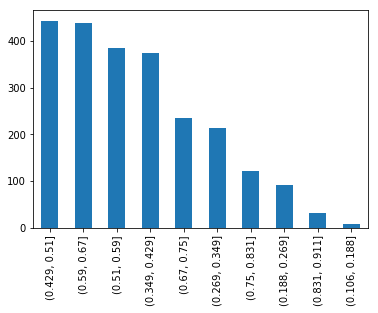

In [446]:
df_combi['B_index'].value_counts(bins=10).plot(kind = 'bar')